# Comparing Readability

In this notebook:
* Readability Score Boxplot
* Related to time: average readability per week and month
* Statistical analysis
    * Q-Q plot and Shapiro to test assumption of normality
    * Levene's to test assumption of homogeneity of variances
    * T-test for two indepedent samples
    * Table with syllables/word and words/sentences to explain differences

In [1]:
import pandas as pd
from math import sqrt
from scipy.stats import ttest_ind, levene, probplot, shapiro

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

## Open Tweets

In [2]:
path_clinton = '../Data/tweets_clinton_20151109_20161109_readability.json'

with open(path_clinton, encoding="utf8") as f:
    tweets_clinton = pd.read_json(f, orient='columns', convert_axes=True, dtype=True, lines=False)
    
tweets_clinton['created_at'] = tweets_clinton['created_at'].dt.tz_localize(tz='GMT', ambiguous='infer').dt.tz_convert(tz='US/Eastern')

In [3]:
path_trump = '../Data/tweets_trump_20151109_20161109_readability.json'

with open(path_trump, encoding="utf8") as f:
    tweets_trump = pd.read_json(f, orient='columns', convert_axes=True, dtype=True, lines=False)
    
tweets_trump['created_at'] = tweets_trump['created_at'].dt.tz_localize(tz='GMT', ambiguous='infer').dt.tz_convert(tz='US/Eastern')

In [4]:
all_tweets = pd.concat([tweets_clinton, tweets_trump], sort=False)

## Exploring Data

### Readability Score Boxplot

In [5]:
readability_grade_columns = [
    'readability grades Kincaid', 'readability grades ARI', 'readability grades Coleman-Liau',
    'readability grades GunningFogIndex', 'readability grades SMOGIndex'
]
readability_nongrade_columns = [
    'readability grades FleschReadingEase', 'readability grades LIX',
    'readability grades RIX', 'readability grades DaleChallIndex'
]
readability_columns = [
    'readability grades Kincaid', 'readability grades ARI', 'readability grades Coleman-Liau',
    'readability grades FleschReadingEase', 'readability grades GunningFogIndex',
    'readability grades LIX', 'readability grades SMOGIndex', 'readability grades RIX',
    'readability grades DaleChallIndex'
]

In [6]:
# Seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")

In [7]:
# Colors and mean line styling
my_pal = {"Clinton": "royalblue", "Trump": "orangered"}
meanlineprops = dict(linestyle='--', linewidth=2.5, color='white')

my_pal_source = {
    "All Sources": "mediumblue",
    "TweetDeck": "orchid",
    "iPhone": "gold",
    "Android": "limegreen",
    "Web": "teal",
    "Media Studio": "sienna"
}

In [8]:
all_tweets_grade_melt = all_tweets.melt(id_vars = 'user',
                          value_vars = readability_grade_columns,
                          var_name = 'columns')

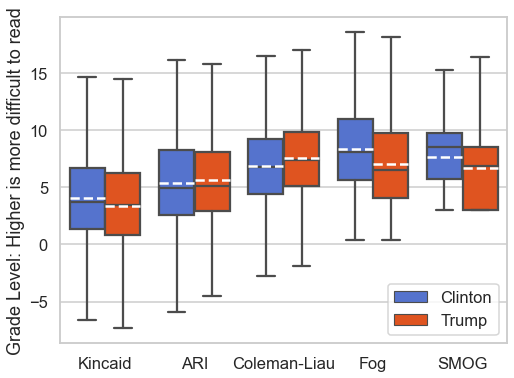

In [9]:
# Size
plt.figure(figsize=(8, 6))

# Plot
b = sns.boxplot(
    data = all_tweets_grade_melt,
    hue = 'user',
    x = 'columns',
    y = 'value',
    palette = my_pal,
    showfliers = False,
    showmeans = True,
    meanline = True,
    meanprops = meanlineprops
).set(
    xlabel='', 
    ylabel='Grade Level: Higher is more difficult to read'
)

# Tick labels x axis
plt.xticks([0, 1, 2, 3, 4], ['Kincaid', 'ARI', 'Coleman-Liau', 'Fog', 'SMOG'])

# Legend
plt.legend(title='')

# Save plot to Plots folder
plt.savefig('../Plots/boxplot_gradescores_trumpclinton.pdf', format = 'pdf', bbox_inches = "tight")

In [10]:
all_tweets_melt = all_tweets.melt(id_vars = 'user',
                        value_vars = 'readability grades FleschReadingEase',
                        var_name = 'columns')

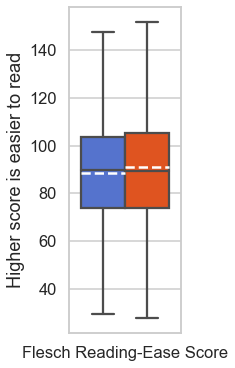

In [11]:
# Size
plt.figure(figsize=(2, 6))

# Plot
f = sns.boxplot(
        data = all_tweets_melt,
        hue = 'user',
        x = 'columns',
        y = 'value',
        palette = my_pal,
        showfliers = False,
        showmeans = True,
        meanline = True,
        meanprops = meanlineprops
).set(
    xlabel='', 
    ylabel='Higher score is easier to read'
)

plt.xticks([0], ['Flesch Reading-Ease Score'])

# Legend
plt.legend((), (), title = None, framealpha = 0)


# Save plot to Plots folder
plt.savefig('../Plots/boxplot_fre_trumpclinton.pdf', format = 'pdf', bbox_inches = "tight")

### Complexity over Time: Comparing Trump and Clinton

In [12]:
tweets_trump_per_week = tweets_trump.resample('W', on='created_at').mean()
tweets_trump_per_week['user'] = 'Trump'

tweets_clinton_per_week = tweets_clinton.resample('W', on='created_at').mean()
tweets_clinton_per_week['user'] = 'Clinton'

all_tweets_per_week = pd.concat([tweets_trump_per_week, tweets_clinton_per_week], sort=False)

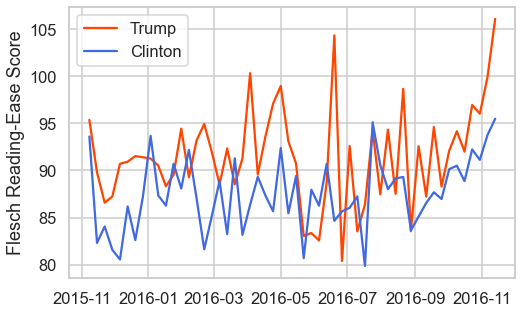

In [13]:
# Size
plt.figure(figsize=(8, 5))

# Plot
e = sns.lineplot(
    x = all_tweets_per_week.index,
    y = all_tweets_per_week['readability grades FleschReadingEase'],
    hue = all_tweets_per_week['user'],
    palette = my_pal,
    ci = None
).set(
    xlabel = '', 
    ylabel = 'Flesch Reading-Ease Score',
    title = ''
)

plt.legend(title='')

plt.savefig('../Plots/lineplot_readability_week.pdf', format = 'pdf', bbox_inches = "tight")

In [14]:
tweets_trump_per_month = tweets_trump.resample('M', on='created_at').mean()
tweets_trump_per_month['user'] = 'Trump'

tweets_clinton_per_month = tweets_clinton.resample('M', on='created_at').mean()
tweets_clinton_per_month['user'] = 'Clinton'

all_tweets_per_month = pd.concat([tweets_trump_per_month, tweets_clinton_per_month], sort=False)

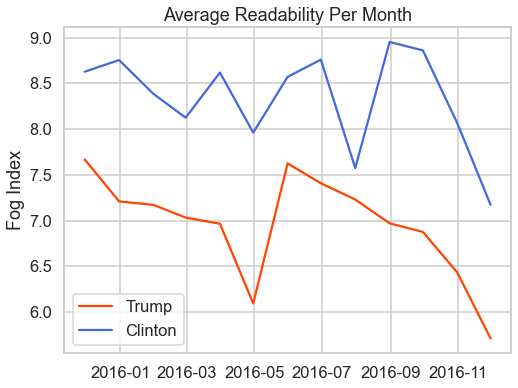

In [15]:
# Size
plt.figure(figsize=(8, 6))

# Plot
e = sns.lineplot(
    x = all_tweets_per_month.index,
    y = all_tweets_per_month['readability grades GunningFogIndex'],
    hue = all_tweets_per_month['user'],
    palette = my_pal,
    ci = None
).set(
    xlabel = '', 
    ylabel = 'Fog Index',
    title = 'Average Readability Per Month'
)

plt.legend(title='')

## Statistical Analysis

In [16]:
readability = 'readability grades FleschReadingEase'

### T-test

In [17]:
print(tweets_trump[readability].mean(), tweets_trump[readability].median(), tweets_trump[readability].var())

91.20735857441207 89.29115384615 757.7947950608203


In [18]:
print(tweets_clinton[readability].mean(), tweets_clinton[readability].median(), tweets_clinton[readability].var())

88.39242846928825 89.6067307692 578.4049966397413


**Check assumptions: normally distributed group and homogeneity of variances**

Text(0.5, 1.0, 'Trump Flesch Reading-Ease Score Q-Q Plot')

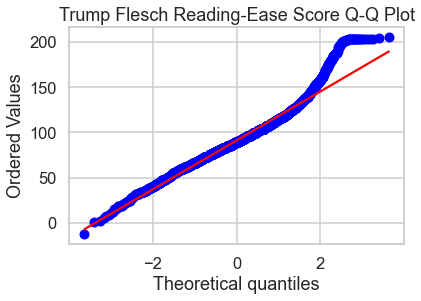

In [19]:
probplot(tweets_trump[readability].dropna(), dist = "norm", plot = plt)
plt.title("Trump Flesch Reading-Ease Score Q-Q Plot")

In [20]:
shapiro(tweets_trump[readability].dropna())

ShapiroResult(statistic=0.9641343951225281, pvalue=1.9837532461881534e-33)

Text(0.5, 1.0, 'Clinton Flesch Reading-Ease Score Q-Q Plot')

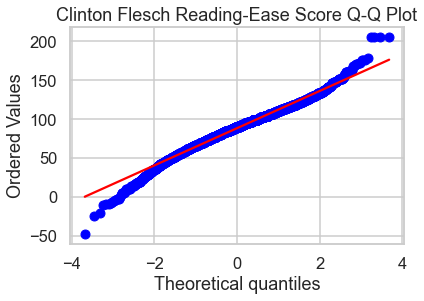

In [21]:
probplot(tweets_clinton[readability].dropna(), dist = "norm", plot = plt)
plt.title("Clinton Flesch Reading-Ease Score Q-Q Plot")

In [22]:
shapiro(tweets_clinton[readability].dropna())

c:\users\leony\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9859466552734375, pvalue=5.5671937509668695e-24)

In [23]:
levene(tweets_trump[readability].dropna(), tweets_clinton[readability])

LeveneResult(statistic=37.72250932705802, pvalue=8.438361710256689e-10)

**T-test**

In [24]:
ttest_ind(tweets_trump[readability], tweets_clinton[readability], nan_policy = 'omit')

Ttest_indResult(statistic=5.7141059751305585, pvalue=1.1315549239657124e-08)

**Cohen's d**

In [25]:
# function to calculate Cohen's d for independent samples
# based on https://machinelearningmastery.com/effect-size-measures-in-python/
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1.index), len(d2.index)
    # calculate the variance of the samples
    s1, s2 = d1.var(), d2.var()
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = d1.mean(), d2.mean()
    # calculate the effect size
    return (u1 - u2) / s

In [26]:
cohend(tweets_trump[readability].dropna(), tweets_clinton[readability])

0.10960057063474242

### Check syllables/word and words/sentence

In [27]:
sentence_info_features =  [
        'sentence info syll_per_word',
        'sentence info words_per_sentence',                
        'sentence info syllables',
        'sentence info words',
        'sentence info sentences'
    ]

sentence_info_tabel = pd.DataFrame()

In [28]:
for feature in sentence_info_features:
    mean_tr = round(tweets_trump[feature].mean(), 2)
    sd_tr = round(tweets_trump[feature].std(), 2)
    mean_cl = round(tweets_clinton[feature].mean(), 2)
    sd_cl = round(tweets_clinton[feature].std(), 2)
    t_value = round(ttest_ind(tweets_trump[feature], tweets_clinton[feature], nan_policy = 'omit')[1], 3)
    cohen_d = round(cohend(tweets_trump[feature].dropna(), tweets_clinton[feature]), 2)
    
    row = pd.Series([mean_tr, sd_tr, mean_cl, sd_cl, t_value, cohen_d])
    row_df = pd.DataFrame([row], index = [feature[14:]])
    sentence_info_tabel = pd.concat([row_df, sentence_info_tabel])
    
sentence_info_tabel

,0,1,2,3,4,5
sentences,1.97,0.84,1.81,0.81,0.000,0.19
words,19.01,6.33,19.43,5.09,0.000,-0.07
syllables,23.55,9.20,24.22,7.43,0.000,-0.08
words_per_sentence,11.20,5.89,12.48,5.67,0.000,-0.22
syll_per_word,1.23,0.31,1.25,0.27,0.001,-0.06


In [29]:
print(sentence_info_tabel.to_latex(bold_rows = True))

\begin{tabular}{lrrrrrr}
\toprule
{} &      0 &     1 &      2 &     3 &      4 &     5 \\
\midrule
\textbf{sentences         } &   1.97 &  0.84 &   1.81 &  0.81 &  0.000 &  0.19 \\
\textbf{words             } &  19.01 &  6.33 &  19.43 &  5.09 &  0.000 & -0.07 \\
\textbf{syllables         } &  23.55 &  9.20 &  24.22 &  7.43 &  0.000 & -0.08 \\
\textbf{words\_per\_sentence} &  11.20 &  5.89 &  12.48 &  5.67 &  0.000 & -0.22 \\
\textbf{syll\_per\_word     } &   1.23 &  0.31 &   1.25 &  0.27 &  0.001 & -0.06 \\
\bottomrule
\end{tabular}

